In [1]:
import os
import sys
import keras
import tarfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.engine.training import Model
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Add, Dropout, Flatten, Dense, Activation

In [13]:
ls Images

n02085620-Chihuahua/


In [10]:
import cv2

BASEPATH = './Images'
LABELS = set()
paths = []
    
for d in os.listdir(BASEPATH):
    LABELS.add(d)
    paths.append((BASEPATH + '/' + d, d))

# resizing and converting to RGB
def load_and_preprocess_image(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [12]:
X, y = [], []
i, j = 0, 0

for path, label in paths:
    i += 1
    if i == 18 or i == 23 or i == 41 or i == 49 or i == 90: continue # Faulty Directories
    if path == "./Images/.DS_Store": continue
    if path == "./Images/desktop.ini": continue
        
    print('Dir:', i, path)
    print('Image:', j)
    
    for image_path in os.listdir(path):
        j += 1
        
        image = load_and_preprocess_image(path + "/" + image_path)
            
        X.append(image)
        y.append(label)

Dir: 2 ./Images/n02085620-Chihuahua
Image: 0


error: OpenCV(4.4.0) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-gi6lxw0x/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [4]:
Y = []

# Cleaning the names of the directories/targets
for i in y:
    Y.append(i.split('-')[1])

In [5]:
from sklearn.model_selection import train_test_split

encoder = LabelBinarizer()

X = np.array(X)
y = encoder.fit_transform(np.array(Y))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=87)

Text(0.5, 0, 'English_setter')

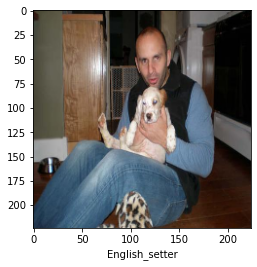

In [6]:
plt.imshow(x_train[0])
plt.xlabel(y_train[0])

In [7]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [8]:
print('X_train shape: ', x_train.shape)
print('Y_train shape: ', len(y_train))

X_train shape:  (14754, 224, 224, 3)
Y_train shape:  14754


Train: X=(14754, 224, 224, 3), y=14754
Test: X=(4919, 224, 224, 3), y=4919


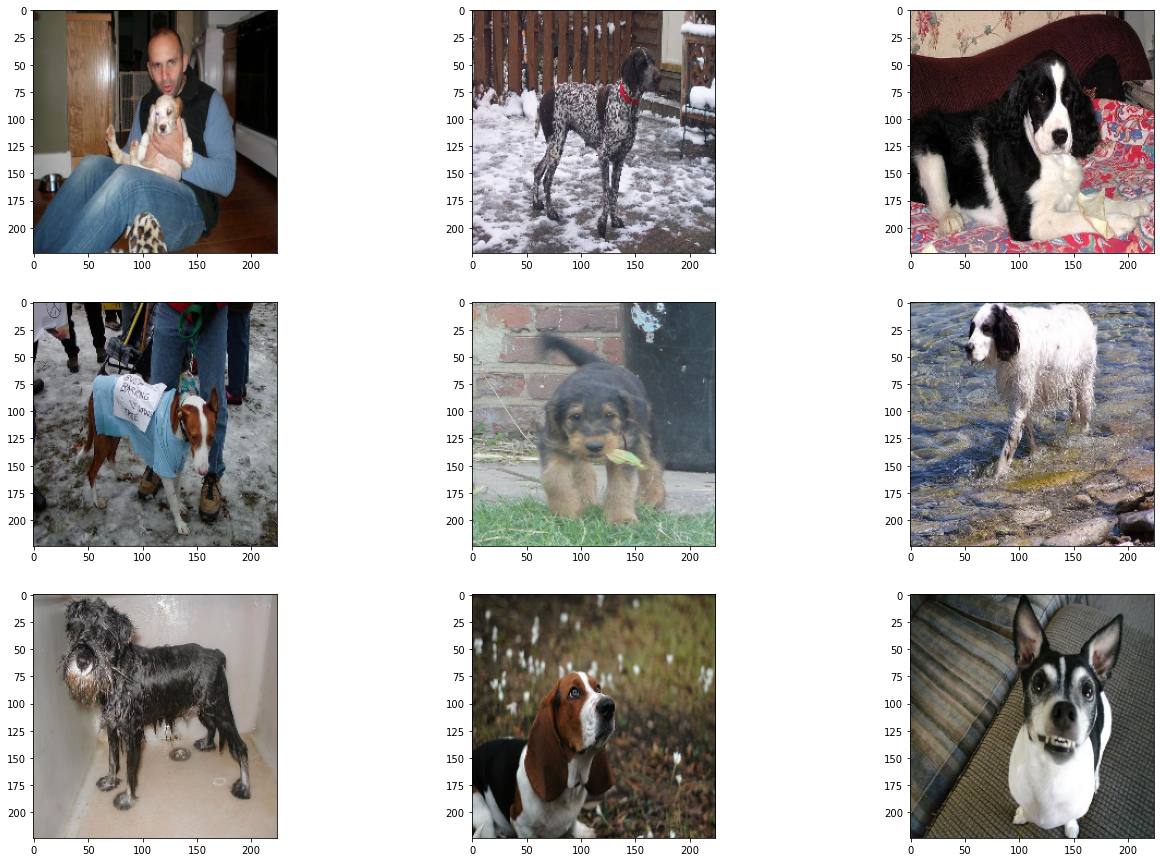

In [153]:
from matplotlib import pyplot

print('Train: X=%s, y=%s' % (x_train.shape, len(y_train)))
print('Test: X=%s, y=%s' % (x_test.shape, len(y_test)))

for i in range(9):
    pyplot.subplot(330 + 1 + i)
    plt.subplots_adjust(right=3, top=3)
    pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
    
pyplot.show()

In [14]:
from keras.applications import inception_v3

input_size = 224
num_classes = 115

inception_bottleneck = inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling='avg')
temp_train = inception_bottleneck.predict(x_train, batch_size=32, verbose=1)
temp_test = inception_bottleneck.predict(x_test, batch_size=32, verbose=1)

print('InceptionV3 train bottleneck features shape: {} size: {:,}'.format(temp_train.shape, temp_train.size))
print('InceptionV3 test bottleneck features shape: {} size: {:,}'.format(temp_test.shape, temp_test.size))

154/154 [==============================] - 284s 2s/step
InceptionV3 train bottleneck features shape: (14754, 2048) size: 30,216,192
InceptionV3 test bottleneck features shape: (4919, 2048) size: 10,074,112


In [35]:
model = Sequential()  

model.add(Flatten())

model.add(Dense(1024, activation='elu'))  
model.add(Dropout(0.45))  
model.add(Dense(512, activation='elu'))  
model.add(Dropout(0.35))  

model.add(Dense(num_classes, activation='softmax'))

In [36]:
model.compile(optimizer='adam',  
              loss='categorical_crossentropy',
              metrics=['accuracy'])  

In [37]:
history = model.fit(temp_train, Y_train,  
          epochs = 15,  
          batch_size = 32,  
          validation_data = (temp_test, Y_test))

Epoch 1/15
462/462 [==============================] - 10s 22ms/step - loss: 1.6817 - accuracy: 0.6076 - val_loss: 0.9575 - val_accuracy: 0.7434
Epoch 2/15
462/462 [==============================] - 9s 20ms/step - loss: 1.2165 - accuracy: 0.7005 - val_loss: 0.8781 - val_accuracy: 0.7520
Epoch 3/15
462/462 [==============================] - 11s 23ms/step - loss: 1.1096 - accuracy: 0.7190 - val_loss: 0.9067 - val_accuracy: 0.7544
Epoch 4/15
462/462 [==============================] - 10s 21ms/step - loss: 1.0784 - accuracy: 0.7303 - val_loss: 0.9839 - val_accuracy: 0.7577
Epoch 5/15
462/462 [==============================] - 10s 21ms/step - loss: 1.0375 - accuracy: 0.7380 - val_loss: 0.9510 - val_accuracy: 0.7536
Epoch 6/15
462/462 [==============================] - 10s 22ms/step - loss: 1.0247 - accuracy: 0.7443 - val_loss: 0.9331 - val_accuracy: 0.7536
Epoch 7/15
462/462 [==============================] - 11s 24ms/step - loss: 1.0070 - accuracy: 0.7487 - val_loss: 0.9469 - val_accuracy: 

accuracy: 77.31%


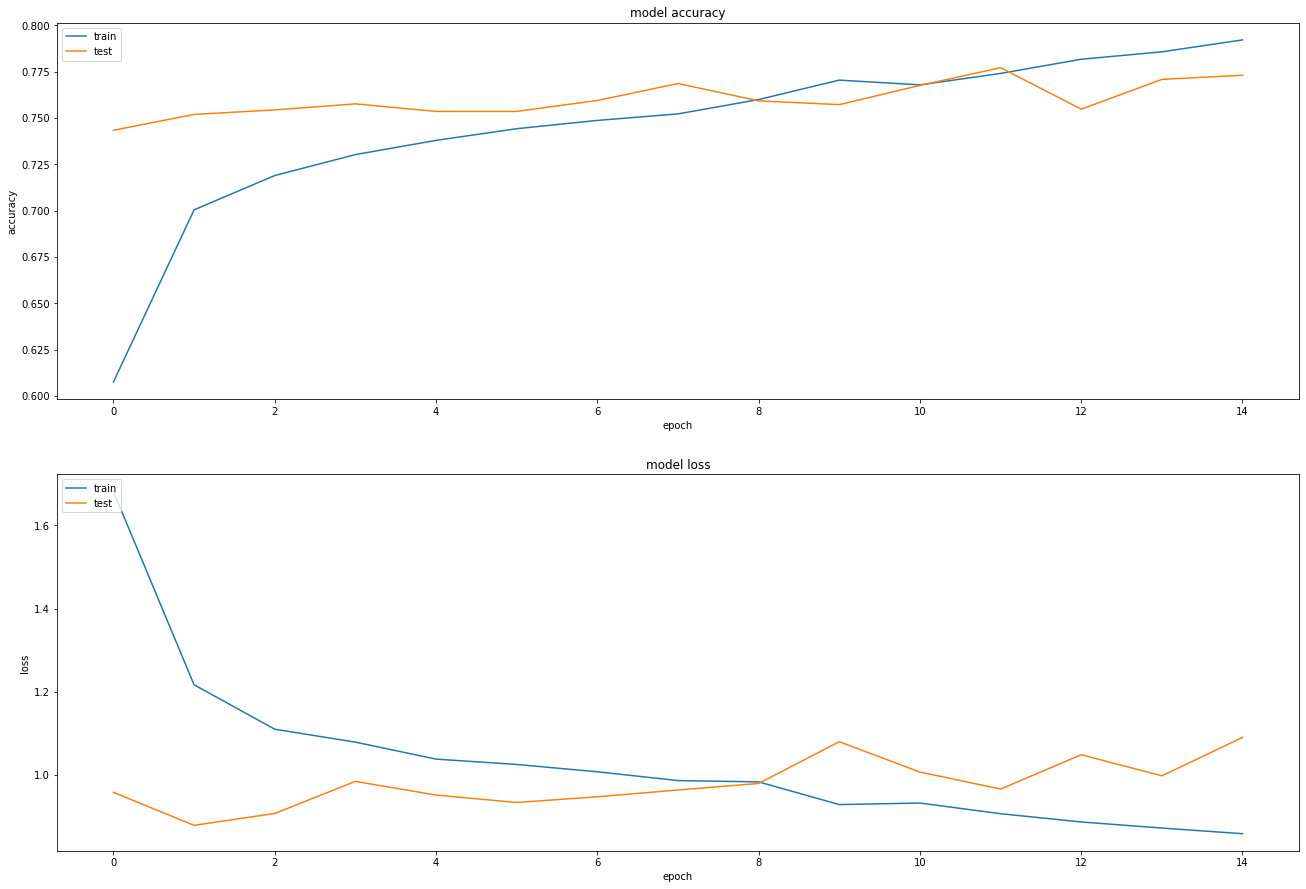

In [158]:
score = model.evaluate(temp_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
  
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

plt.subplots_adjust(right=3, top=3)
plt.show()

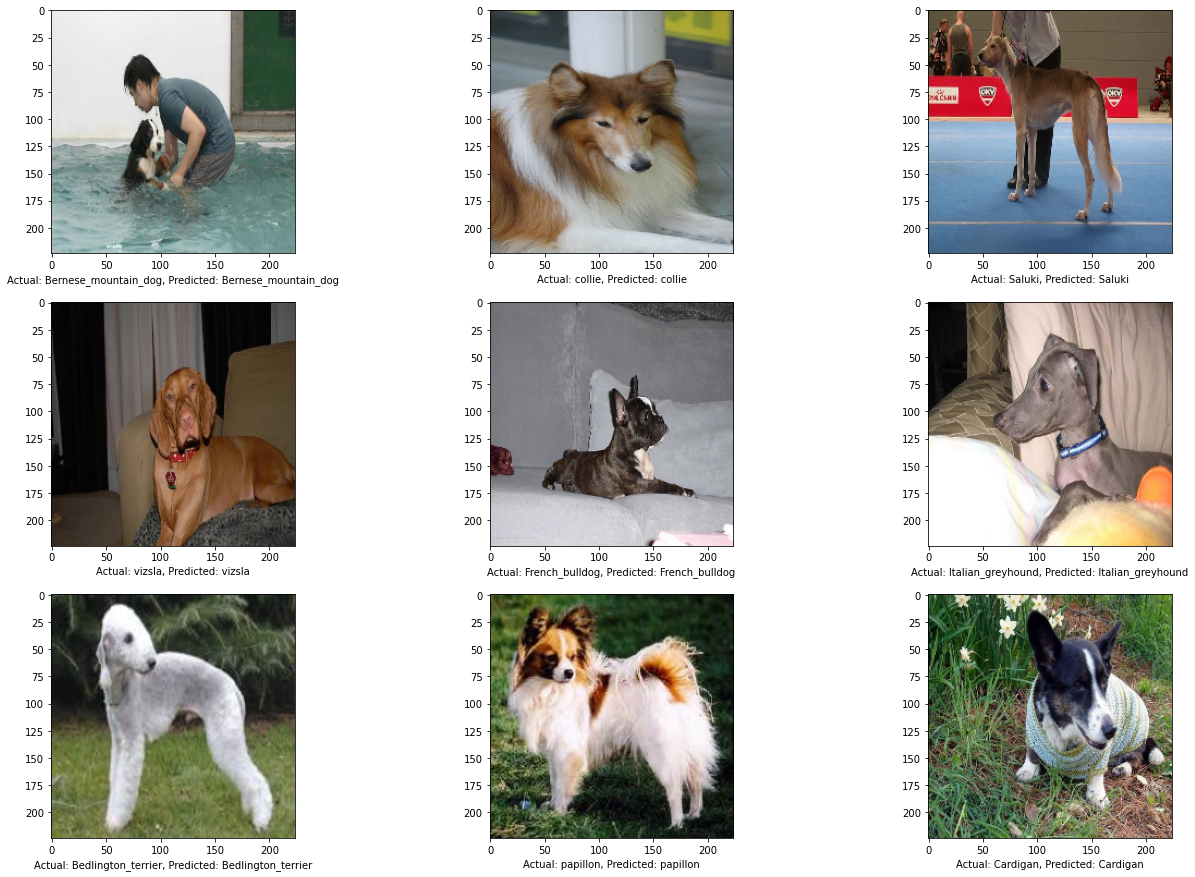

In [152]:
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.xlabel("Actual: " + y_test[i] + ", Predicted: " + results[i])
    pyplot.imshow(x_test[i], cmap=pyplot.get_cmap('gray'))
    
    plt.subplots_adjust(right=3, top=3)

pyplot.show()

In [72]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
